In [1]:
!pip install tensorflow-ranking
!pip install tensorflow
!pip install category_encoders
!pip install rbo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-serving-api to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import rbo
import category_encoders as ce
from sklearn.datasets import dump_svmlight_file
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import ndcg_score

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_ranking as tfr
from tensorflow.keras.layers import Input, Concatenate, Embedding, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

Mounted at /content/drive


### STANDARD RELEVANCE SCORE
- 0 (no clicks)
- 1 (click)
- 2 (transaction)

In [15]:
X_train_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/train.csv')
y_train_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_train.csv')

X_val_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/vali.csv')
y_val_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_vali.csv')

X_test_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/test.csv')
y_test_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_test.csv')

### NDCG METRICS FOR THE NEURAL NETWORK

In [16]:
pd.set_option('display.max_columns', None)

In [17]:
X_train_pp.head()

,qid,is_mobile,adult_count,child_count,length_of_stay,booking_window,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,number_of_amenities,point_of_sale_target,geo_location_country_target,destination_id_target,prop_id_target,checkin_day_0,checkin_day_1,checkin_day_2,checkin_day_3,checkin_day_4,checkin_day_5,checkin_day_6,checkout_day_0,checkout_day_1,checkout_day_2,checkout_day_3,checkout_day_4,checkout_day_5,checkout_day_6,checkin_month_1,checkin_month_2,checkin_month_3,checkin_month_4,checkin_month_5,checkin_month_6,checkin_month_7,checkin_month_8,checkin_month_9,checkin_month_10,checkin_month_11,checkin_month_12
0,47,0,1.020496,1.0,-0.315826,-0.393425,4,-0.157157,3,1,0,2,1.0,1,0,1,0,0,0,1,1,1,0,1,1,0,0,0,1,0,0,8,0.079125,0.074679,0.095423,0.075758,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
1,47,0,1.020496,1.0,-0.315826,-0.393425,4,-0.157157,3,1,1,1,2.0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,7,0.079125,0.074679,0.095423,0.115730,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
2,47,0,1.020496,1.0,-0.315826,-0.393425,5,-0.128536,4,1,0,3,3.0,0,0,1,0,1,0,1,1,1,1,1,1,0,0,0,1,0,0,9,0.079125,0.074679,0.095423,0.224597,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
3,47,0,1.020496,1.0,-0.315826,-0.393425,4,-0.347965,4,1,0,5,4.0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,6,0.079125,0.074679,0.095423,0.018275,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
4,47,0,1.020496,1.0,-0.315826,-0.393425,4,-0.395666,4,1,0,4,5.0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,4,0.079125,0.074679,0.095423,0.073171,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False


In [18]:
X_train_pp = X_train_pp.drop(columns=['rank_noad'])
X_val_pp = X_val_pp.drop(columns=['rank_noad'])
X_test_pp = X_test_pp.drop(columns=['rank_noad'])

In [19]:
def ndcg_metric_30(y_true, y_pred):
    k = 30
    y_score = tf.squeeze(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    dcg = tf.reduce_sum(gain / discounts)

    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [20]:
def ndcg_metric_20(y_true, y_pred):
    k = 20
    y_score = tf.squeeze(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    dcg = tf.reduce_sum(gain / discounts)

    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [21]:
def ndcg_metric_10(y_true, y_pred):
    k = 10
    y_score = tf.squeeze(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    dcg = tf.reduce_sum(gain / discounts)

    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

In [22]:
def ndcg_metric_5(y_true, y_pred):
    k = 5
    y_score = tf.squeeze(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)

    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order)

    gain = tf.pow(2.0, y_true_sorted) - 1.0
    discounts = tf.math.log(tf.range(tf.shape(y_true_sorted)[0], dtype=tf.float32) + 2.0) / tf.math.log(2.0)

    dcg = tf.reduce_sum(gain / discounts)

    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_y_true = tf.gather(y_true, ideal_order)[:k]
    ideal_gain = tf.pow(2.0, ideal_y_true) - 1.0
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts[:tf.shape(ideal_gain)[0]])

    ndcg = tf.where(tf.equal(ideal_dcg, 0), 0.0, dcg / ideal_dcg)
    return ndcg

### NEURAL NETWORK ARCHITECTURE

In [23]:
query_id_train_pp = X_train_pp['qid']
query_id_val_pp = X_val_pp['qid']
query_id_test_pp = X_test_pp['qid']


X_train_2_pp = X_train_pp.drop(columns=['qid'])
X_train_arr_pp = X_train_2_pp.values.astype(float)

X_val_2_pp = X_val_pp.drop(columns=['qid'])
X_val_arr_pp = X_val_2_pp.values.astype(float)

X_test_2_pp = X_test_pp.drop(columns=['qid'])
X_test_arr_pp = X_test_2_pp.values.astype(float)


y_train_array_pp = y_train_pp.values.astype(int).ravel()
y_train_array_pp = y_train_array_pp.flatten().astype(float)

y_val_array_pp = y_val_pp.values.astype(int).ravel()
y_val_array_pp = y_val_array_pp.flatten().astype(float)

y_test_array_pp = y_test_pp.values.astype(int).ravel()
y_test_array_pp = y_test_array_pp.flatten().astype(float)

In [24]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True, monitor='val_ndcg_metric_5', mode='max')

np.random.seed(42)
tf.random.set_seed(42)

# Input layers for features and search_id
input_features = Input(shape=(X_train_arr_pp.shape[1],), name='features')
input_query_id = Input(shape=(1,), name='search_id')

# Embedding or concatenation layer for search_id
concatenated_inputs = Concatenate()([input_features, input_query_id])

# Define the rest of your model architecture
dense_layer_1 = Dense(128, activation='relu')(concatenated_inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
#dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
#dense_layer_3 = Dense(1024, activation='relu')(dense_layer_2)
#dropout_layer = Dropout(0.3)(dense_layer_3)
#dense_layer_4 = Dense(512, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(256, activation='relu')(dense_layer_1)
dense_layer_6 = Dense(128, activation='relu')(dense_layer_5)
dense_layer_7 = Dense(64, activation='relu')(dense_layer_6)
dense_layer_8 = Dense(32, activation='relu')(dense_layer_7)
output_layer = Dense(1)(dense_layer_8)

#Losses
loss_ndcgapprox = tfr.keras.losses.ApproxNDCGLoss(temperature=0.1)
loss_clickeml = tfr.keras.losses.ClickEMLoss()

#Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the model
model = Model(inputs=[input_features, input_query_id], outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_ndcgapprox, metrics=[ndcg_metric_5])

# Fit the model with both features and search_id
history = model.fit({'features': X_train_arr_pp, 'search_id': query_id_train_pp}, y_train_array_pp,
                    epochs=50, validation_data=({'features': X_val_arr_pp, 'search_id': query_id_val_pp}, y_val_array_pp),
                    verbose=True, batch_size=64, callbacks=[early_stopping_cb])

Epoch 1/50
13702/13702 [==============================] - 69s 5ms/step - loss: -0.0719 - ndcg_metric_5: 0.3869 - val_loss: -0.0732 - val_ndcg_metric_5: 0.3828
Epoch 2/50
13702/13702 [==============================] - 67s 5ms/step - loss: -0.0719 - ndcg_metric_5: 0.3869 - val_loss: -0.0732 - val_ndcg_metric_5: 0.3828
Epoch 3/50
13702/13702 [==============================] - 66s 5ms/step - loss: -0.0719 - ndcg_metric_5: 0.3870 - val_loss: -0.0732 - val_ndcg_metric_5: 0.3828
Epoch 4/50
13702/13702 [==============================] - 67s 5ms/step - loss: -0.0719 - ndcg_metric_5: 0.3876 - val_loss: -0.0732 - val_ndcg_metric_5: 0.3828
Epoch 5/50
13702/13702 [==============================] - 69s 5ms/step - loss: -0.0719 - ndcg_metric_5: 0.3880 - val_loss: -0.0732 - val_ndcg_metric_5: 0.3828
Epoch 6/50
13702/13702 [==============================] - 70s 5ms/step - loss: -0.0719 - ndcg_metric_5: 0.3873 - val_loss: -0.0732 - val_ndcg_metric_5: 0.3828


### NDCG COMPUTATION FOR PREDICTIONS

In [25]:
def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [26]:
y_test_pred = y_test_pp['relevance']
query_id_test_pp = X_test_pp['qid']
qids = np.unique(query_id_test_pp)

ndcg_5 = list()
ndcg_10 = list()
ndcg_20 = list()
ndcg_30 = list()
predict_values = list()

for i, qid in tqdm(enumerate(qids[:]), total=len(qids)):
    query_id_test_pp = X_test_pp['qid']
    y = y_test_pred[query_id_test_pp == qid]

    if np.sum(y) == 0:
        continue

    X_test_2_pp = X_test_pp[X_test_pp['qid'] == qid]

    query_id_test_pp = X_test_2_pp['qid']

    X_test_2_pp = X_test_2_pp.drop(columns=['qid'])
    X_test_arr_pp = X_test_2_pp.values.astype(float)

    predictions = model.predict({'features': X_test_arr_pp, 'search_id': query_id_test_pp}, verbose=False)
    predictions = predictions.flatten()
    predict_values.append([predictions])

    for i in [5,10,20,30]:
      idcg = ndcg(y, y, k=i)
      eval(f"ndcg_{i}").append(ndcg(predictions, y, k=i) / idcg)


print(f'NDCG K5 {np.mean(ndcg_5)}')
print(f'NDCG K10 {np.mean(ndcg_10)}')
print(f'NDCG K20 {np.mean(ndcg_20)}')
print(f'NDCG K30 {np.mean(ndcg_30)}')

100%|██████████| 12779/12779 [19:56<00:00, 10.68it/s]

NDCG K5 0.1678415685377167
NDCG K10 0.23677712178936325
NDCG K20 0.3335979623488874
NDCG K30 0.38030904720319686


In [107]:
unique_qid = X_test_pp['qid'].unique()
testtt = X_test_pp[X_test_pp['qid'].isin(unique_qid[:500])]
testtt.shape[0]
t_testtt = y_test_pp[:testtt.shape[0]]

In [108]:
y_test_pred = t_testtt['relevance']
query_id_test_pp = testtt['qid']
qids = np.unique(query_id_test_pp)

ndcg_5 = list()
ndcg_10 = list()
ndcg_20 = list()
ndcg_30 = list()
predict_values = list()

for i, qid in tqdm(enumerate(qids[:]), total=len(qids)):
    query_id_test_pp = testtt['qid']
    y = y_test_pred[query_id_test_pp == qid]

    if np.sum(y) == 0:
        continue

    X_test_2_pp = testtt[testtt['qid'] == qid]

    query_id_test_pp = X_test_2_pp['qid']

    X_test_2_pp = X_test_2_pp.drop(columns=['qid'])
    X_test_arr_pp = X_test_2_pp.values.astype(float)

    predictions = model.predict({'features': X_test_arr_pp, 'search_id': query_id_test_pp}, verbose=False)
    predictions = predictions.flatten()
    predict_values.append([predictions])

    for i in [5,10,20,30]:
      idcg = ndcg(y, y, k=i)
      eval(f"ndcg_{i}").append(ndcg(predictions, y, k=i) / idcg)


print(f'NDCG K5 {np.mean(ndcg_5)}')
print(f'NDCG K10 {np.mean(ndcg_10)}')
print(f'NDCG K20 {np.mean(ndcg_20)}')
print(f'NDCG K30 {np.mean(ndcg_30)}')

100%|██████████| 500/500 [00:38<00:00, 12.99it/s]

NDCG K5 0.501869321551276
NDCG K10 0.5617920037012842
NDCG K20 0.6005449305711997
NDCG K30 0.6115901741421633


In [37]:
pred_rbo = model.predict({'features': X_test_arr_pp, 'search_id': query_id_test_pp})

9159/9159 [==============================] - 17s 2ms/step


In [ ]:
scratch_nn_andcg = [0.51, 0.57, 0.61, 0.63]

WITHOUT PROP_ID 2 EPOCHS
- K5 0.0872718979999956
- NDCG K10 0.12586011957430057
- NDCG K20 0.20052890579009477
- NDCG K30 0.31414689685750613

WITHOUT PROP_ID 25 EPOCHS
- NDCG K5 0.4783645998206443
- NDCG K10 0.5365250795771305
- NDCG K20 0.5828685803829531
- NDCG K30 0.5950768832585804




RUNNING just 2 EPOCHS:
- NDCG K5 0.21395663719615304
- NDCG K10 0.2882926997434941
- NDCG K20 0.38191068440407794
- NDCG K30 0.4157879526293884

RUNNING 11 EPOCHS:
- NDCG K5 0.2593172827907193
- NDCG K10 0.33880707482557637
- NDCG K20 0.4193044875602093
- NDCG K30 0.44707773677879903

### PENDING TO COMPUTE RBO

In [81]:
len(predict_values)

500

In [48]:
rbo.RankingSimilarity(np.argsort(np.array(predict_values[0]))[0].tolist(),np.argsort(np.array(predict_values[1]))[0].tolist()).rbo()

0.41299866611675545

In [82]:
len(predict_values2)

500

In [85]:
predict_values[:2]

[[array([ 1.7916496 ,  1.6572597 ,  1.528369  ,  1.3368037 ,  0.96729124,
          1.3491042 ,  1.0677645 ,  0.94756055,  0.81275594,  0.5601784 ,
          1.3901912 ,  0.58318233,  0.5909226 ,  0.9924338 ,  0.70431936,
          0.5142576 ,  0.3686579 ,  0.11152542,  0.16763079,  0.15408671,
         -0.18819773,  0.24172854,  0.29134405, -0.21294165,  0.53911215],
        dtype=float32)],
 [array([ 2.44446   ,  1.5254047 ,  1.6997004 ,  1.6167855 ,  1.0502257 ,
          1.1247458 ,  0.9310522 ,  1.0742755 ,  0.96121955,  0.91325593,
          0.33600974,  0.5003464 ,  0.2654798 , -0.19075704,  0.0427537 ,
          0.0987227 , -0.76512456,  0.07446647, -0.84468484, -0.5554378 ,
         -0.39141536], dtype=float32)]]

In [83]:
comp_rbo = []
for i in range(len(predict_values)):
  comp_rbo.append(rbo.RankingSimilarity(np.argsort(np.array(predict_values[i]))[0].tolist(),np.argsort(np.array(predict_values2[i]))[0].tolist()).rbo())

np.mean(comp_rbo)

0.7930397250543556

In [12]:
s = [0.4, 0.5, 0.5, 0.3]
t = [0.6,0.7,0.7,0.5]

rbo.RankingSimilarity(np.argsort(np.array(s)).tolist(),np.argsort(np.array(t)).tolist()).rbo()

1.0

### PLOT COMPARISON

In [27]:
#XGBRANK
xgb_rank_lambdamart = [0.5738, 0.6259, 0.6713, 0.6830]
xgb_norank_lambdamart = [0.33, 0.40, 0.48, 0.50]



#LGBMRANK
lgbm_norank_lambdamart = [0.31, 0.39, 0.46, 0.49]



#ScratchNN
scratchnn_rank_andcg = [0.45, 0.51, 0.56, 0.57]
scratchnn_norank_andcg = [0.17, 0.24, 0.34, 0.38]



#AllRank NN
allrank_norank_andcg = [0.36, 0.43, 0.49, 0.51]

ks = ['K5', 'K10', 'K20', 'K30']
original_df = [0.47, 0.51, 0.57, 0.61]

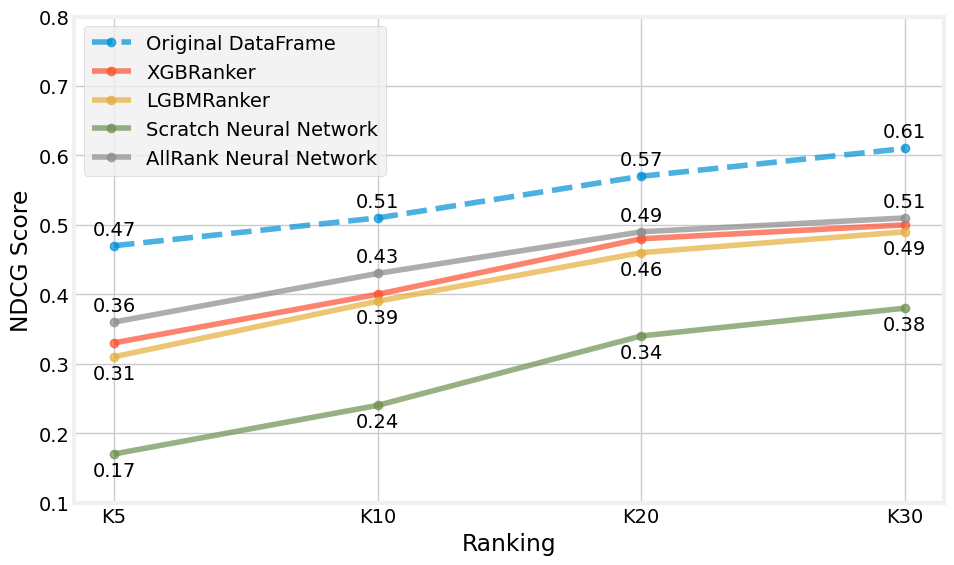

In [31]:
## NO RANK

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6), facecolor='white')
plt.gca().set_facecolor('white')

plt.plot(ks, original_df, label='Original DataFrame', alpha=0.7, linestyle='--', marker='o')
plt.plot(ks, xgb_norank_lambdamart, label='XGBRanker', alpha=0.7, marker='o')
plt.plot(ks, lgbm_norank_lambdamart, label='LGBMRanker', alpha=0.7, marker='o')
plt.plot(ks, scratchnn_norank_andcg, label='Scratch Neural Network', alpha=0.7, marker='o')
plt.plot(ks, allrank_norank_andcg, label='AllRank Neural Network', alpha=0.7, marker='o')

for i, (x, y) in enumerate(zip(ks, original_df)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

#for i, (x, y) in enumerate(zip(ks, xgb_norank_lambdamart)):
 #   plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

for i, (x, y) in enumerate(zip(ks, lgbm_norank_lambdamart)):
    plt.text(x, y-0.01, f'{y:.2f}', ha='center', va='top')

for i, (x, y) in enumerate(zip(ks, scratchnn_norank_andcg)):
    plt.text(x, y-0.01, f'{y:.2f}', ha='center', va='top')

for i, (x, y) in enumerate(zip(ks, allrank_norank_andcg)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

plt.title('')
plt.ylabel('NDCG Score')
plt.xlabel('Ranking')
plt.legend(loc='upper left')
plt.ylim(0.1,0.8)
plt.show()

In [91]:
ks = ['K5', 'K10', 'K20', 'K30']

scratch_nn_sdg = [0.45, 0.51, 0.56, 0.57]
nn_allrank = [0.59, 0.64, 0.68, 0.69]
xgboost_ndcg = [0.57, 0.63, 0.67, 0.68]
lightgbm_ndcg = [0.56, 0.61, 0.66, 0.67]

original_df = [0.47, 0.51, 0.57, 0.61]

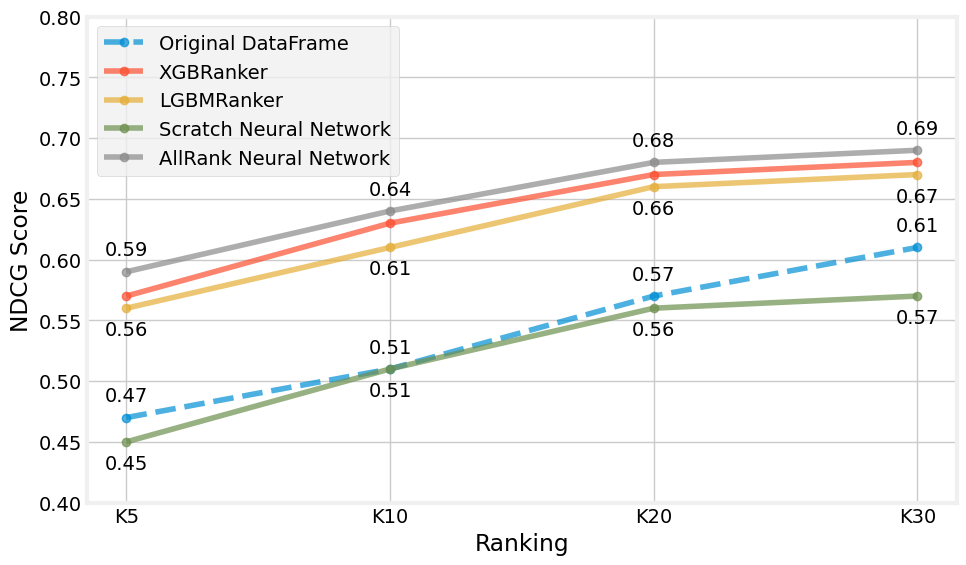

In [32]:
ks = ['K5', 'K10', 'K20', 'K30']

scratch_nn_sdg = [0.45, 0.51, 0.56, 0.57]
nn_allrank = [0.59, 0.64, 0.68, 0.69]
xgboost_ndcg = [0.57, 0.63, 0.67, 0.68]
lightgbm_ndcg = [0.56, 0.61, 0.66, 0.67]

original_df = [0.47, 0.51, 0.57, 0.61]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6), facecolor='white')
plt.gca().set_facecolor('white')

plt.plot(ks, original_df, label='Original DataFrame', alpha=0.7, linestyle='--', marker='o')
plt.plot(ks, xgboost_ndcg, label='XGBRanker', alpha=0.7, marker='o')
plt.plot(ks, lightgbm_ndcg, label='LGBMRanker', alpha=0.7, marker='o')
plt.plot(ks, scratch_nn_sdg, label='Scratch Neural Network', alpha=0.7, marker='o')
plt.plot(ks, nn_allrank, label='AllRank Neural Network', alpha=0.7, marker='o')

for i, (x, y) in enumerate(zip(ks, original_df)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

#for i, (x, y) in enumerate(zip(ks, xgboost_ndcg)):
 #   plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

for i, (x, y) in enumerate(zip(ks, lightgbm_ndcg)):
    plt.text(x, y-0.01, f'{y:.2f}', ha='center', va='top')

for i, (x, y) in enumerate(zip(ks, scratch_nn_sdg)):
    plt.text(x, y-0.01, f'{y:.2f}', ha='center', va='top')

for i, (x, y) in enumerate(zip(ks, nn_allrank)):
    plt.text(x, y+0.01, f'{y:.2f}', ha='center', va='bottom')

plt.title('')
plt.ylabel('NDCG Score')
plt.xlabel('Ranking')
plt.legend(loc='upper left')
plt.ylim(0.4,0.8)
plt.show()

### PRICE_BUCKET RELEVANCE SCORE
Adding to the traditional relevance score, 1 if price bucket is between 1-3, and 2 if 4-5

In [ ]:
X_train_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/train.csv')
y_train_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_train.csv')

X_val_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/vali.csv')
y_val_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_vali.csv')

X_test_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/test.csv')
y_test_pp = pd.read_csv('/content/drive/MyDrive/Expedia/allRankNew/allRank/expedia_data/Millionrows_allRank/target_relevance/y_test.csv')

In [ ]:
query_id_train_pp = X_train_pp['qid']
query_id_val_pp = X_val_pp['qid']
query_id_test_pp = X_test_pp['qid']


X_train_2_pp = X_train_pp.drop(columns=['qid'])
X_train_arr_pp = X_train_2_pp.values.astype(float)

X_val_2_pp = X_val_pp.drop(columns=['qid'])
X_val_arr_pp = X_val_2_pp.values.astype(float)

X_test_2_pp = X_test_pp.drop(columns=['qid'])
X_test_arr_pp = X_test_2_pp.values.astype(float)


y_train_array_pp = y_train_pp.values.astype(int).ravel()
y_train_array_pp = y_train_array_pp.flatten().astype(float)

y_val_array_pp = y_val_pp.values.astype(int).ravel()
y_val_array_pp = y_val_array_pp.flatten().astype(float)

y_test_array_pp = y_test_pp.values.astype(int).ravel()
y_test_array_pp = y_test_array_pp.flatten().astype(float)

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_ndcg_metric_5', mode='max')

np.random.seed(42)
tf.random.set_seed(42)

# Input layers for features and search_id
input_features = Input(shape=(X_train_arr_pp.shape[1],), name='features')
input_query_id = Input(shape=(1,), name='search_id')

# Embedding or concatenation layer for search_id
concatenated_inputs = Concatenate()([input_features, input_query_id])

# Define the rest of your model architecture
dense_layer_1 = Dense(128, activation='relu')(concatenated_inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
dropout_layer = Dropout(0.3)(dense_layer_2)
dense_layer_3 = Dense(1024, activation='relu')(dense_layer_2)
dropout_layer = Dropout(0.3)(dense_layer_3)
dense_layer_4 = Dense(512, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(256, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(128, activation='relu')(dense_layer_5)
dense_layer_7 = Dense(64, activation='relu')(dense_layer_6)
dense_layer_8 = Dense(32, activation='relu')(dense_layer_7)
output_layer = Dense(1)(dense_layer_8)

#Losses
loss_ndcgapprox = tfr.keras.losses.ApproxNDCGLoss(temperature=0.1)
loss_clickeml = tfr.keras.losses.ClickEMLoss()

#Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the model
model = Model(inputs=[input_features, input_query_id], outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_ndcgapprox, metrics=[ndcg_metric_30, ndcg_metric_20, ndcg_metric_10, ndcg_metric_5])

# Fit the model with both features and search_id
history = model.fit({'features': X_train_arr_pp, 'search_id': query_id_train_pp}, y_train_array_pp,
                    epochs=50, validation_data=({'features': X_val_arr_pp, 'search_id': query_id_val_pp}, y_val_array_pp),
                    verbose=True, batch_size=64, callbacks=[early_stopping_cb])

Epoch 1/50
13702/13702 [==============================] - 174s 12ms/step - loss: -0.0719 - ndcg_metric_30: 0.3614 - ndcg_metric_20: 0.3614 - ndcg_metric_10: 0.3615 - ndcg_metric_5: 0.3868 - val_loss: -0.0732 - val_ndcg_metric_30: 0.3181 - val_ndcg_metric_20: 0.3191 - val_ndcg_metric_10: 0.3260 - val_ndcg_metric_5: 0.3589
Epoch 2/50
13702/13702 [==============================] - 168s 12ms/step - loss: -0.0719 - ndcg_metric_30: 0.3614 - ndcg_metric_20: 0.3614 - ndcg_metric_10: 0.3616 - ndcg_metric_5: 0.3869 - val_loss: -0.0732 - val_ndcg_metric_30: 0.3181 - val_ndcg_metric_20: 0.3191 - val_ndcg_metric_10: 0.3260 - val_ndcg_metric_5: 0.3589
Epoch 3/50
13702/13702 [==============================] - 168s 12ms/step - loss: -0.0719 - ndcg_metric_30: 0.3613 - ndcg_metric_20: 0.3613 - ndcg_metric_10: 0.3615 - ndcg_metric_5: 0.3870 - val_loss: -0.0732 - val_ndcg_metric_30: 0.3181 - val_ndcg_metric_20: 0.3191 - val_ndcg_metric_10: 0.3260 - val_ndcg_metric_5: 0.3589
Epoch 4/50
13702/13702 [=======

In [ ]:
y_test_pred = y_test_pp['relevance']
query_id_test_pp = X_test_pp['qid']
qids = np.unique(query_id_test_pp)

ndcg_5 = list()
ndcg_10 = list()
ndcg_20 = list()
ndcg_30 = list()
predict_values = list()

for i, qid in tqdm(enumerate(qids[:]), total=len(qids)):
    query_id_test_pp = X_test_pp['qid']
    y = y_test_pred[query_id_test_pp == qid]

    if np.sum(y) == 0:
        continue

    X_test_2_pp = X_test_pp[X_test_pp['qid'] == qid]

    query_id_test_pp = X_test_2_pp['qid']

    X_test_2_pp = X_test_2_pp.drop(columns=['qid'])
    X_test_arr_pp = X_test_2_pp.values.astype(float)

    predictions = model.predict({'features': X_test_arr_pp, 'search_id': query_id_test_pp}, verbose=False)
    predictions = predictions.flatten()
    predict_values.append([predictions])

    for i in [5,10,20,30]:
      idcg = ndcg(y, y, k=i)
      eval(f"ndcg_{i}").append(ndcg(predictions, y, k=i) / idcg)


print(f'NDCG K5 {np.mean(ndcg_5)}')
print(f'NDCG K10 {np.mean(ndcg_10)}')
print(f'NDCG K20 {np.mean(ndcg_20)}')
print(f'NDCG K30 {np.mean(ndcg_30)}')

 36%|███▋      | 4649/12779 [07:22<13:13, 10.25it/s]

### REVIEW RATING - REVIEW COUNT RELEVANCE SCORE

- If relevance is not equal to 0:
    - If review count is greater than 200 and review rating is 4, sum 2
    - If review_count is greater than 200 and review rating is 5, sum 3
    - If review count is greater than 200 and review rating is 3 or below, deduct 1
    - If review count is lower than 200 but review rating is equal to 4 or 5, add 1


In [ ]:
X_train_pp_rr = pd.read_csv('/content/drive/MyDrive/Expedia/Data/workstation_1millionrows/target_combined_click_reviewrating_review_count_relevance/train.csv')
y_train_pp_rr = pd.read_csv('/content/drive/MyDrive/Expedia/Data/workstation_1millionrows/target_combined_click_reviewrating_review_count_relevance/y_train.csv')

X_val_pp_rr = pd.read_csv('/content/drive/MyDrive/Expedia/Data/workstation_1millionrows/target_combined_click_reviewrating_review_count_relevance/vali.csv')
y_val_pp_rr = pd.read_csv('/content/drive/MyDrive/Expedia/Data/workstation_1millionrows/target_combined_click_reviewrating_review_count_relevance/y_vali.csv')

X_test_pp_rr = pd.read_csv('/content/drive/MyDrive/Expedia/Data/workstation_1millionrows/target_combined_click_reviewrating_review_count_relevance/test.csv')
y_test_pp_rr = pd.read_csv('/content/drive/MyDrive/Expedia/Data/workstation_1millionrows/target_combined_click_reviewrating_review_count_relevance/y_test.csv')

In [ ]:
X_train_pp_rr = X_train_pp_rr.drop(columns=['prop_id_target'])
X_val_pp_rr = X_val_pp_rr.drop(columns=['prop_id_target'])
X_test_pp_rr = X_test_pp_rr.drop(columns=['prop_id_target'])

In [ ]:
query_id_train_pp_rr = X_train_pp_rr['qid']
query_id_val_pp_rr = X_val_pp_rr['qid']
query_id_test_pp_rr = X_test_pp_rr['qid']


X_train_2_pp_rr = X_train_pp_rr.drop(columns=['qid'])
X_train_arr_pp_rr = X_train_2_pp_rr.values.astype(float)

X_val_2_pp_rr = X_val_pp_rr.drop(columns=['qid'])
X_val_arr_pp_rr = X_val_2_pp_rr.values.astype(float)

X_test_2_pp_rr = X_test_pp_rr.drop(columns=['qid'])
X_test_arr_pp_rr = X_test_2_pp_rr.values.astype(float)


y_train_array_pp_rr = y_train_pp_rr.values.astype(int).ravel()
y_train_array_pp_rr = y_train_array_pp_rr.flatten().astype(float)

y_val_array_pp_rr = y_val_pp_rr.values.astype(int).ravel()
y_val_array_pp_rr = y_val_array_pp_rr.flatten().astype(float)

y_test_array_pp_rr = y_test_pp_rr.values.astype(int).ravel()
y_test_array_pp_rr = y_test_array_pp_rr.flatten().astype(float)

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True, monitor='val_ndcg_metric_5', mode='max')

np.random.seed(42)
tf.random.set_seed(42)

# Input layers for features and search_id
input_features = Input(shape=(X_train_arr_pp_rr.shape[1],), name='features')
input_query_id = Input(shape=(1,), name='search_id')

# Embedding or concatenation layer for search_id
concatenated_inputs = Concatenate()([input_features, input_query_id])

# Define the rest of your model architecture
dense_layer_1 = Dense(128, activation='relu')(concatenated_inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
#dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
#dense_layer_3 = Dense(1024, activation='relu')(dense_layer_2)
#dropout_layer = Dropout(0.3)(dense_layer_3)
#dense_layer_4 = Dense(512, activation='relu')(dense_layer_3)
#dense_layer_5 = Dense(256, activation='relu')(dense_layer_4)
#dense_layer_6 = Dense(128, activation='relu')(dense_layer_5)
dense_layer_7 = Dense(64, activation='relu')(dense_layer_1)
dense_layer_8 = Dense(32, activation='relu')(dense_layer_7)
output_layer = Dense(1)(dense_layer_8)

#Losses
loss_ndcgapprox = tfr.keras.losses.ApproxNDCGLoss(temperature=0.1)
loss_clickeml = tfr.keras.losses.ClickEMLoss()

#Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the model
model = Model(inputs=[input_features, input_query_id], outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_ndcgapprox, metrics=[ndcg_metric_5])

# Fit the model with both features and search_id
history = model.fit({'features': X_train_arr_pp_rr, 'search_id': query_id_train_pp_rr}, y_train_array_pp_rr,
                    epochs=50, validation_data=({'features': X_val_arr_pp_rr, 'search_id': query_id_val_pp_rr}, y_val_array_pp_rr),
                    verbose=True, batch_size=64, callbacks=[early_stopping_cb])

In [ ]:
unique_qid_rr = X_test_pp_rr['qid'].unique()
testtt_rr = X_test_pp_rr[X_test_pp_rr['qid'].isin(unique_qid_rr[:3000])]
testtt_rr.shape[0]
t_testtt_rr = y_test_pp_rr[:testtt_rr.shape[0]]

In [ ]:
y_test_pred_rr = t_testtt_rr['relevance']
query_id_test_pp_rr = testtt_rr['qid']
qids_rr = np.unique(query_id_test_pp_rr)

ndcg_5_rr = list()
ndcg_10_rr = list()
ndcg_20_rr = list()
ndcg_30_rr = list()
predict_values_rr = list()

for i, qid in tqdm(enumerate(qids_rr[:]), total=len(qids_rr)):
    query_id_test_pp_rr = testtt_rr['qid']
    y = y_test_pred_rr[query_id_test_pp_rr == qid]

    if np.sum(y) == 0:
        continue

    X_test_2_pp = testtt_rr[testtt_rr['qid'] == qid]

    query_id_test_pp_rr = X_test_2_pp['qid']

    X_test_2_pp = X_test_2_pp.drop(columns=['qid'])
    X_test_arr_pp = X_test_2_pp.values.astype(float)

    predictions = model.predict({'features': X_test_arr_pp, 'search_id': query_id_test_pp_rr}, verbose=False)
    predictions = predictions.flatten()
    predict_values_rr.append([predictions])

    for i in [5,10,20,30]:
      idcg = ndcg(y, y, k=i)
      eval(f"ndcg_{i}").append(ndcg(predictions, y, k=i) / idcg)


print(f'NDCG K5 {np.mean(ndcg_5_rr)}')
print(f'NDCG K10 {np.mean(ndcg_10_rr)}')
print(f'NDCG K20 {np.mean(ndcg_20_rr)}')
print(f'NDCG K30 {np.mean(ndcg_30_rr)}')